In [13]:
import os
import pandas as pd
import datetime as dt
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from cdlib import algorithms, viz
from collections import Counter
import seaborn as sns
import nltk
import numpy as np
from collections import Counter
import leidenalg as la
import statistics
import scipy
import random
import igraph as ig
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
random.seed(0)

In [3]:
# Import data
data = pd.read_pickle('/Users/D/edgelist.pkl') 
nodes_attributes = pd.read_pickle('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/full_nodelist_25_05_21.pkl')
vaccine_stance = pd.read_pickle('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Vaccine Atttitude Classifier/authors_vaccination_stance_ML_results.pkl')

In [4]:
# Merge node attributes with results from vaccination stance classifier
nodes_attributes = nodes_attributes.merge(vaccine_stance, left_on='id', right_on='author_id', how='left', suffixes=('', '_author'))

<AxesSubplot:ylabel='Frequency'>

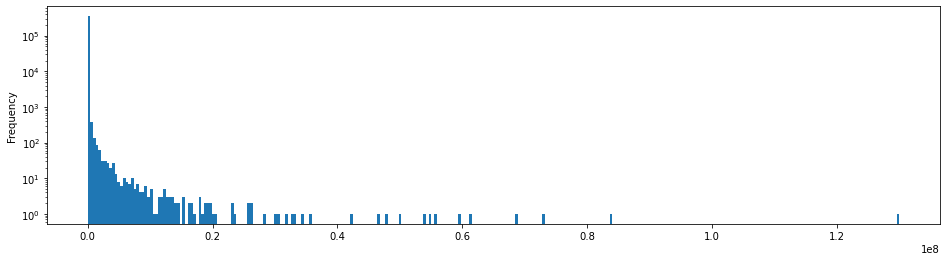

In [15]:
# Distribution of followers
nodes_attributes['followers_count'].plot(kind='hist', logy=True, figsize=[16,4], bins=300)

<AxesSubplot:ylabel='Frequency'>

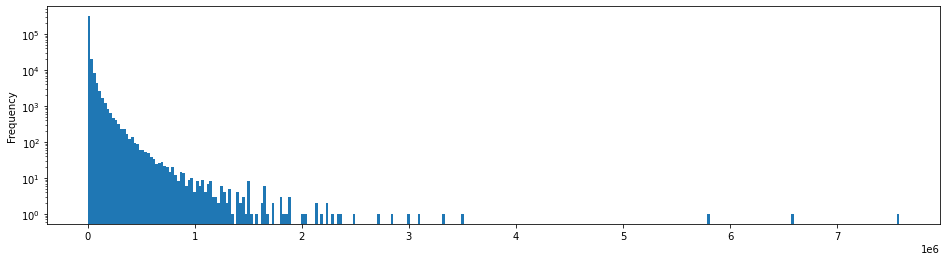

In [16]:
#Tweet amount distribution
nodes_attributes['tweet_count'].plot(kind='hist', logy=True, figsize=[16,4], bins=300)

In [17]:
# See what accounts have the biggest tweet count  

nodes_attributes[nodes_attributes['tweet_count']>1000000 ]

,created_at,description,id,name,username,followers_count,following_count,tweet_count,mean,count,vaccine_stance
125,2014-01-07T07:14:28.000Z,Minutenaktuelle News von jetzt auch mit Youtub...,2280206959,🎲 Policon automatisches Nachrichtenportal 👽,FreieWeltEu,686,2209,1438914,0.115364,5565.0,pro_neutral
1574,2010-07-21T22:27:05.000Z,"Wir bieten Ihnen Webhosting, Webdesign, Domain...",169251474,joKotten Web&Service,jokottenweb,817,528,1225969,0.154083,649.0,pro_neutral
1961,2012-07-26T13:48:05.000Z,Aktuelle Meldungen des Tages auf einer Webseite.,718145940,Cityreport24,CityReport,2077,4919,1157897,0.148240,1619.0,pro_neutral
2190,2014-06-03T17:24:01.000Z,Zyite is global retailer.,2543982944,Zyite.com,zyiteblog,1742,3663,1656367,0.000000,12.0,pro_neutral
2519,2009-03-17T05:03:31.000Z,"International Relations, Geoeconomics, Geopoli...",24842995,Nino Brodin,Orgetorix,3272,5000,1066395,0.116279,129.0,pro_neutral
...,...,...,...,...,...,...,...,...,...,...,...
348882,2010-05-19T01:24:09.000Z,"Noticias de Venezuela Lunes May 24, 2021 el $ ...",145459615,DolarToday®,DolarToday,3735658,3515,2133008,NaN,NaN,NaN
348884,2010-03-18T14:02:00.000Z,Información e Investigación. \nDESCARGA NUESTR...,124172948,La Patilla,la_patilla,7073110,181,5786940,NaN,NaN,NaN
349789,2010-07-12T15:24:32.000Z,Geo is Pakistan's No. 1 TV Channel catering la...,165796189,Geo News Urdu,geonews_urdu,2992346,10,3319157,NaN,NaN,NaN
351714,2009-03-08T19:32:04.000Z,Jernih Melihat Dunia,23343960,Kompas.com,kompascom,8149995,25,1874023,NaN,NaN,NaN


In [19]:
# Check for missing values in user names
nodes_attributes.name.isna().value_counts()

False    353743
Name: name, dtype: int64

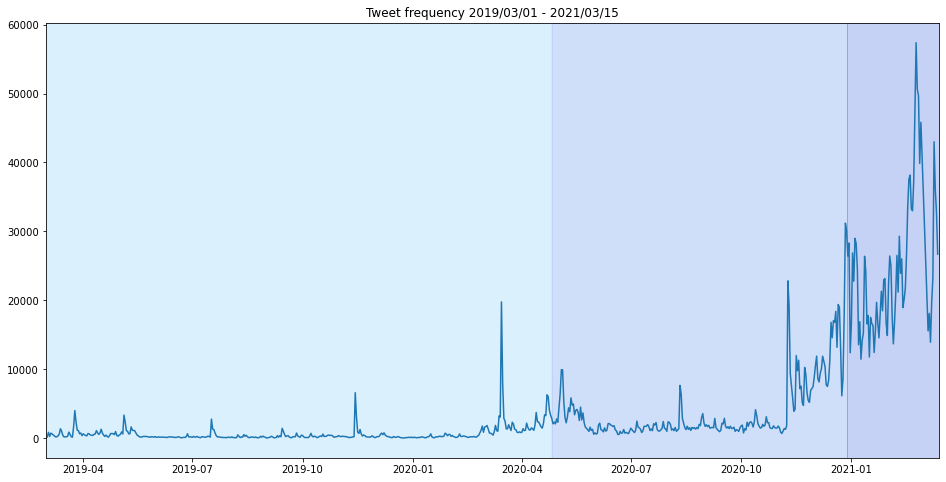

In [20]:
# Plot frequency of tweets by day
tweet_frequency_plot = data.groupby(data['created_at'].dt.date).size().reset_index(name='Count')
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2019,3,1), dt.date(2020,4,25), color='lightskyblue', alpha=0.3)
plt.axvspan(dt.date(2020,4,26), dt.date(2020,12,28), color='cornflowerblue', alpha=0.3)
plt.axvspan(dt.date(2020,12,28), dt.date(2021,3,15), color='royalblue', alpha=0.3)
plt.plot(tweet_frequency_plot.created_at, tweet_frequency_plot.Count )
plt.title('Tweet frequency 2019/03/01 - 2021/03/15')
plt.show()

In [21]:
# Create edglists from dataset

def create_edgelist(type, startdate, enddate):
# date format = YYYY-MM-DD
    selection = data.loc[(data['created_at'] > startdate) & (data['created_at'] <= enddate)& (data['type']==type)]
    if type == 'retweeted':
        return(selection[['author_id','id_retweeted_author']].groupby(['author_id','id_retweeted_author']).size().reset_index(name='weight').rename(columns={'author_id':"source", 'id_retweeted_author': "target"}))
    elif  type == 'replied_to':
         return(selection[['author_id','in_reply_to_user_id']].groupby(['author_id','in_reply_to_user_id']).size().reset_index(name='weight').rename(columns={'author_id':"source", 'in_reply_to_user_id': "target"}))
    elif  type == 'quoted':
        return(selection[['author_id','conversation_id']].groupby(['author_id','conversation_id']).size().reset_index(name='weight'))


In [22]:
#Retweet networks
Period1_edgelist_rt = create_edgelist('retweeted','2019-03-01','2020-03-25')
Period2_edgelist_rt = create_edgelist('retweeted','2020-03-25','2020-12-28')
Period3_edgelist_rt = create_edgelist('retweeted','2020-12-28','2021-03-15')

#Reply networks
Period1_edgelist_rp = create_edgelist('replied_to','2019-03-01','2020-03-25')
Period2_edgelist_rp = create_edgelist('replied_to','2020-03-25','2020-12-28')
Period3_edgelist_rp = create_edgelist('replied_to','2020-12-28','2021-03-15')

## Network analysis using iGraph

In [23]:
# Create retweet graphs from pandas 
G1RT = ig.Graph.TupleList(Period1_edgelist_rt.itertuples(index=False), directed=False, weights='weights')
G2RT = ig.Graph.TupleList(Period2_edgelist_rt.itertuples(index=False), directed=False, weights='weights')
G3RT = ig.Graph.TupleList(Period3_edgelist_rt.itertuples(index=False), directed=False, weights='weights')

# Create retweet graphs from pandas 
G1RP = ig.Graph.TupleList(Period1_edgelist_rp.itertuples(index=False), directed=False, weights='weights')
G2RP = ig.Graph.TupleList(Period2_edgelist_rp.itertuples(index=False), directed=False, weights='weights')
G3RP = ig.Graph.TupleList(Period3_edgelist_rp.itertuples(index=False), directed=False, weights='weights')

In [24]:
# loop over graph to add attributes (takes forever so it will be rather done after calculating network metrics)
def add_attributes(x):
    for i in range(0,len(x.vs)):
        print('\r',i,'of ',len(x.vs), end='')
        user_id = x.vs[i]['name']
        # x.vs[i]['username'] = attributes['username']
        try:
            if nodes_attributes.loc[nodes_attributes.id==user_id, 'vaccine_stance'].values[0] == 'anti_vaxx':
                x.vs[i]['vaccine_stance'] = 1
            else:
                x.vs[i]['vaccine_stance'] = 0
        except:
            x.vs[i]['vaccine_stance'] = 0

In [14]:
# Add vaccine stance to network models

add_attributes(G1RT)
add_attributes(G2RT)
add_attributes(G3RT)

add_attributes(G1RP)
add_attributes(G2RP)
add_attributes(G3RP)

 119360 of  119361

In [15]:
# Retweet graphs overview
print('G1RT', G1RT.summary(),'\n \n','G2RT', G2RT.summary(),'\n \n','G3RT', G3RT.summary())

G1RT IGRAPH UN-- 51799 107082 -- 
+ attr: name (v), vaccine_stance (v), weights (e) 
 
 G2RT IGRAPH UN-- 123464 389602 -- 
+ attr: name (v), vaccine_stance (v), weights (e) 
 
 G3RT IGRAPH UN-- 145770 718329 -- 
+ attr: name (v), vaccine_stance (v), weights (e)


In [16]:
# Replies graphs overview
print('G1RP', G1RP.summary(),'\n \n','G2RP', G2RP.summary(),'\n \n','G3RP', G3RP.summary())

G1RP IGRAPH UN-- 29107 36348 -- 
+ attr: name (v), vaccine_stance (v), weights (e) 
 
 G2RP IGRAPH UN-- 94296 222373 -- 
+ attr: name (v), vaccine_stance (v), weights (e) 
 
 G3RP IGRAPH UN-- 119361 349599 -- 
+ attr: name (v), vaccine_stance (v), weights (e)


### Community detection using iGraphs Leiden algorithm implementation

In [17]:
# Run Leiden algorithm and return clustering element containing graph, communities and subgraphs
def leiden(graph):
    graphname = f'{graph=}'.split('=')[0]
    #use built in igraph leiden solution
    comm = graph.community_leiden( objective_function='modularity', weights='weights', resolution_parameter=0.2, initial_membership=None, n_iterations=-1)
    print('modularity =', comm.modularity)
    # print summary of communites and largest communities
    print(comm.summary(verbosity=0))
    a = comm.sizes()
    a.sort(reverse=True)
    print("Biggest communities:" ,a[0:10])
    graph.vs['community'] = comm.membership
    return(comm)

In [18]:
# Export graphml for each identified community
def export_community_subgraphs(comm, name):
    comm.graph.write_graphml(name+'fullgraph.graphml')
    i = 0
    for community in comm.subgraphs():
        i += 1
        # Only include clusters that make up at least 1 percent of the overall network 
        if community.vcount() > int(comm.graph.vcount()*0.025):
            community.write_graphml(name+'community_'+str(i)+'.graphml')

In [22]:
 export_community_subgraphs(leiden(G1RT),"period_1_retweet")
 export_community_subgraphs(leiden(G2RT),"period_2_retweet")
 export_community_subgraphs(leiden(G3RT),"period_3_retweet")


export_community_subgraphs(leiden(G1RP),"period_1_reply")
export_community_subgraphs(leiden(G2RP),"period_2_reply")
export_community_subgraphs(leiden(G3RP),"period_3_reply")

modularity = 0.16101877114545382
Clustering with 51799 elements and 831 clusters
Biggest communities: [44737, 3678, 185, 101, 98, 80, 76, 53, 51, 38]
modularity = 0.4765859026444126
Clustering with 123464 elements and 1877 clusters
Biggest communities: [89869, 18218, 6255, 1490, 416, 198, 138, 126, 121, 120]
modularity = 0.4542375524539193
Clustering with 145770 elements and 2155 clusters
Biggest communities: [107072, 27985, 1718, 382, 284, 278, 231, 223, 220, 98]
modularity = 0.569992117026495
Clustering with 29107 elements and 4912 clusters
Biggest communities: [12373, 1653, 560, 541, 499, 486, 468, 450, 312, 91]
modularity = 0.2406096336818788
Clustering with 94296 elements and 8531 clusters
Biggest communities: [67179, 6179, 1500, 871, 344, 309, 67, 51, 46, 42]
modularity = 0.28838939161886284
Clustering with 119361 elements and 11577 clusters
Biggest communities: [81276, 8949, 3794, 1080, 135, 104, 88, 67, 64, 51]


In [19]:
# Export summary table to Latex-format

retweet_table = pd.DataFrame(retweet_communities, columns=['period','nodes','edges','density','mean_degree'])
with open('/Users/D/Dropbox/Apps/Overleaf/Master_thesis_010621/tables/retweet_communities.tex','w') as tf:
    tf.write(retweet_table.to_latex(header=['Period','Nodes','Edges','Density','Mean Degree'], float_format="{:0.6f}".format ,index=False,
    caption='Retweet networks: Communities in the Covid-19 vaccination-related retweet network on Twitter, accounting for more than 2.5 percent of the overall network size'))

### Get graph level measurements for communities

In [8]:
# Load full list of tweets

all_tweets = pd.read_pickle('/Users/D/final_edgelist_180521.pkl') 

In [5]:
# Reload exported dataset to maintain consistancy across random element in Leiden algorithm

#Retweet
RT1 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_1_retweetcommunity_1.graphml')
RT2 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_1_retweetcommunity_7.graphml')
RT3 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_2_retweetcommunity_1.graphml')
RT4 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_2_retweetcommunity_2.graphml')
RT5 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_2_retweetcommunity_6.graphml')
RT6 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_3_retweetcommunity_3.graphml')
RT7 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_3_retweetcommunity_4.graphml')

#Retweet
RP1 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_1_replycommunity_2.graphml')
RP2 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_1_replycommunity_21.graphml')
RP3 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_2_replycommunity_1.graphml')
RP4 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_2_replycommunity_9.graphml')
RP5 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_3_replycommunity_2.graphml')
RP6 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_3_replycommunity_5.graphml')
RP7 = ig.load('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Network modeling/Network models exports/period_3_replycommunity_19.graphml')


In [6]:
# Function to get the percentage of nodes identified as expressing an anti-vaccination stance

def get_percentage_antivaxx_users(x, tweettype,startdate,enddate ):
    all_authors_linked_to_tweet_content = list(all_tweets['author_id'].loc[(all_tweets['created_at'] > startdate) & (all_tweets['created_at'] <= enddate)&(all_tweets['type']==tweettype)].drop_duplicates())
    vaccine_stance_list = []
    for a in x.vs:
         if a['name'] in all_authors_linked_to_tweet_content:
            vaccine_stance_list.append(a['vaccine_stance'])
    anti_vax = [i for i in vaccine_stance_list if i != 0.0]
    percentage_antivax_users = len(anti_vax)/len(vaccine_stance_list)*100
    return(percentage_antivax_users)

In [7]:
# Get percentages of anti-vaxx users for retweet network 

for c in [[RT1, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT2, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT3, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT4, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT5, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT6, 'retweeted', '2020-12-28','2021-03-15'],
                  [RT7, 'retweeted', '2020-12-28','2021-03-15']]:
    print(get_percentage_antivaxx_users(c[0],c[1],c[2],c[3]))


NameError: name 'all_tweets' is not defined

In [ ]:
for c in [[RP1, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP2, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP3, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP4, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP5, 'replied_to', '2020-12-28','2021-03-15'],
                  [RP6, 'replied_to', '2020-12-28','2021-03-15'],
                  [RP7, 'replied_to', '2020-12-28','2021-03-15']]:
    print(get_percentage_antivaxx_users(c[0],c[1],c[2],c[3]))


NameError: name 'RP1' is not defined

In [ ]:
# Function to get activity measurement for each community

def get_activity_per_community(x, tweettype,startdate,enddate ):
    tweets_in_cluster = all_tweets.loc[(all_tweets['created_at'] > startdate) & (all_tweets['created_at'] <= enddate)&(all_tweets['type']==tweettype)]
    author_per_cluster_list = []
    author_list = []
    for node in x.vs:
        author_list.append(node['name'])
    community_author_list = pd.Series(author_list, name="id").to_frame()
    selection = tweets_in_cluster.merge(community_author_list , left_on='id_author', right_on='id', how='right')
    return(len(selection)/len(author_list))

In [ ]:
# Activity: Get ratio of tweets per author of tweets per cluster (Retweeted)

for c in [[RT1, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT2, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT3, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT4, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT5, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT6, 'retweeted', '2020-12-28','2021-03-15'],
                  [RT7, 'retweeted', '2020-12-28','2021-03-15']]:
    print(get_activity_per_community(c[0],c[1],c[2],c[3]))

2.4350314057715092
2.5250135943447525
3.3641856479987537
9.518992205511033
1.0335731414868106
5.38348027495517
13.719635519028051


In [ ]:
# Activity: Get ratio of tweets per author of tweets per cluster (Replied To )

for c in [[RP1, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP2, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP3, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP4, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP5, 'replied_to', '2020-12-28','2021-03-15'],
                  [RP6, 'replied_to', '2020-12-28','2021-03-15'],
                  [RP7, 'replied_to', '2020-12-28','2021-03-15']]:
    print(get_activity_per_community(c[0],c[1],c[2],c[3]))

2.453083326598238
1.6721113127646703
3.6790663749088255
3.244699789609969
4.730449333136473
5.013297575148061
4.170268845545598


### Exploratory content Analysis: Get the most important word per community

In [9]:
# Only keep relevant columns to help performance
all_tweets = all_tweets[['id_author','text','type','created_at']]


In [14]:
# Get stopwords in German and English (the latter because Twitter users tend to have english profile descriptions )
german_stop_words = stopwords.words('german')
en_stop_words = stopwords.words('english')
german_stop_words.extend(en_stop_words)
german_stop_words.extend(['https','für','in','die', 'der','co','rt','mal','de','nan','eu','schon','eigentlich','schon', 'beim','the', 'and', 'of', 'is', 'she','her','him','he','my','me','it','en','la','por','do','que'])

def tweet_preprocessing(x):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(x))
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Substituting multiple spaces with single space
    text= re.sub(r'\s+', ' ', text, flags=re.I)
    text = text.lower()
    text = ' '.join(re.sub("(@[a-zA-ZäöüÄÖÜß0-9]+)|([^0-9a-zA-ZäöüÄÖÜß \t])|(\w+:\/\/\S+)"," ",text).split())
    return(text)

# Functions for extracting most important words per community/ aggregated profile description or tweets

def get_tfidf_top_features(documents,n_top=20):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.80, min_df=10, max_features=500,ngram_range=(1,1), stop_words=german_stop_words)
  tfidf = tfidf_vectorizer.fit_transform(documents)
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
  return tfidf_feature_names[importance[:n_top]]

def most_common_words_in_graph(graph, tweettype, startdate, enddate):
    selection = all_tweets.loc[(all_tweets['created_at'] > startdate) & (all_tweets['created_at'] <= enddate)& (all_tweets['type']==tweettype)]
    author_list = []
    for node in graph.vs:
        author_list.append(node['name'])
    community_author_list = pd.Series(author_list,
              name="id").to_frame()
    selection = selection.merge(community_author_list , left_on='id_author', right_on='id', how='right').text.apply(lambda x: tweet_preprocessing(x))
    return(get_tfidf_top_features(list(selection),75))

def most_common_words_in_profile_descriptions(graph):
    author_list = []
    for node in graph.vs:
        author_list.append(node['name'])
    community_author_list = pd.Series(author_list,
              name="id").to_frame()
    selection = community_author_list.merge(nodes_attributes , left_on='id', right_on='id', how='left').description.apply(lambda x: tweet_preprocessing(x))
    return(get_tfidf_top_features(list(selection),50))

def unique_words_per_period(l1,l2):
    list_1 = [str(word) for word in l1 if word not in l2]
    list_2 = [str(word) for word in l2 if word not in l1]
    return(list_1)

In [21]:
# Content analysis: Most important words for retweet network

list_mostcommon = []
profile_descriptions = []
for c in [[RT1, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT2, 'retweeted', '2019-03-01', '2020-03-25'],
                  [RT3, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT4, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT5, 'retweeted', '2020-03-25','2020-12-28'],
                  [RT6, 'retweeted', '2020-12-28','2021-03-15'],
                  [RT7, 'retweeted', '2020-12-28','2021-03-15']]:
    list_mostcommon.append(list(most_common_words_in_graph(c[0],c[1],c[2],c[3])))
    profile_descriptions.append(most_common_words_in_profile_descriptions(c[0]))

list_mostcommon_clean = ['RT1','RT2','RT3','RT4','RT5','RT6','RT7']
list_mostcommon_clean[0] = unique_words_per_period(list_mostcommon[0],list_mostcommon[1])
list_mostcommon_clean[1] = unique_words_per_period(list_mostcommon[1],list_mostcommon[0])
list_mostcommon_clean[2] = unique_words_per_period(list_mostcommon[2],list_mostcommon[3])
list_mostcommon_clean[3] = unique_words_per_period(list_mostcommon[3],list_mostcommon[2])
list_mostcommon_clean[4] = list_mostcommon[4]
list_mostcommon_clean[5] = unique_words_per_period(list_mostcommon[5],list_mostcommon[6])
list_mostcommon_clean[6] = unique_words_per_period(list_mostcommon[6],list_mostcommon[5])

content_analysis = pd.DataFrame()
content_analysis['ids'] = ['RT1','RT2','RT3','RT4','RT5','RT6','RT7']
content_analysis['profiles'] = profile_descriptions
content_analysis['important_words'] = list_mostcommon_clean

In [22]:
content_analysis

,ids,profiles,important_words
0,RT1,"[privat, leben, politik, fan, noafd, tweets, i...","[nataliegrams, kind, impfungen, land, tübingen..."
1,RT2,"[afd, freiheit, politik, leben, deutschland, w...","[spahn, deutschen, steinhoefel, ddbnews, impfs..."
2,RT3,"[privat, politik, leben, berlin, tweets, noafd...","[karl, ersten, impfungen, innen, volksverpetze..."
3,RT4,"[freiheit, leben, wer, afd, immer, deutschland...","[shomburg, gates, franz, reitschuster, spahn, ..."
4,RT5,"[like, ig, blm, life, love, gay, el, blacklive...","[5ohvrcslfd, tomzohar, mqauo7vkdr, trixiematte..."
5,RT6,"[privat, fan, leben, politik, berlin, account,...","[karl, lauterbach, impfzentrum, innen, leute, ..."
6,RT7,"[freiheit, leben, liberal, wer, politik, immer...","[impfpflicht, merkel, reitschuster, spahn, wel..."


In [17]:
# Content analysis: Most important words for replied-to network

list_mostcommon_rp = []
profile_descriptions_rp = []
for c in [[RP1, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP2, 'replied_to', '2019-03-01', '2020-03-25'],
                  [RP3, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP4, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP5, 'replied_to', '2020-03-25','2020-12-28'],
                  [RP6, 'replied_to', '2020-12-28','2021-03-15'],
                  [RP7, 'replied_to', '2020-12-28','2021-03-15']]:
    list_mostcommon_rp.append(list(most_common_words_in_graph(c[0],c[1],c[2],c[3])))
    profile_descriptions_rp.append(most_common_words_in_profile_descriptions(c[0]))

list_mostcommon_clean_rp = ['RP1','RP2','RP3','RP4','RP5','RP6','RP7']
list_mostcommon_clean_rp[0] = unique_words_per_period(list_mostcommon_rp[0],list_mostcommon_rp[1])
list_mostcommon_clean_rp[1] = unique_words_per_period(list_mostcommon_rp[1],list_mostcommon_rp[0])
list_mostcommon_clean_rp[2] = unique_words_per_period(list_mostcommon_rp[2],list_mostcommon_rp[3])
list_mostcommon_clean_rp[3] = unique_words_per_period(list_mostcommon_rp[3],list_mostcommon_rp[2])
list_mostcommon_clean_rp[4] = unique_words_per_period(list_mostcommon_rp[4],list_mostcommon_rp[5])
list_mostcommon_clean_rp[5] = unique_words_per_period(list_mostcommon_rp[5],list_mostcommon_rp[4])
list_mostcommon_clean_rp[6] = list_mostcommon_rp[6]

content_analysis_rp = pd.DataFrame()
content_analysis_rp['ids'] = ['RP1','RP2','RP3','RP4','RP5','RP6','RP7']
content_analysis_rp['profiles'] = profile_descriptions_rp
content_analysis_rp['important_words'] = list_mostcommon_clean_rp

In [19]:
content_analysis_rp

,ids,profiles,important_words
0,RP1,"[leben, noafd, politik, immer, privat, mehr, f...","[jensspahn, nataliegrams, impfungen, tagesscha..."
1,RP2,"[politik, tweets, journalist, account, privat,...","[trump, influenza, franz, halt, strobl, natasc..."
2,RP3,"[leben, immer, noafd, politik, fan, privat, me...","[lauterbach, karl, jensspahn, tagesschau, welt..."
3,RP4,"[politik, wien, privat, tweets, journalist, le...","[anschober, rudi, sebastiankurz, pfizer, isabe..."
4,RP5,"[leben, immer, privat, politik, fan, noafd, tw...","[lauterbach, karl, impfpflicht, jensspahn, vir..."
5,RP6,"[politik, wien, privat, tweets, journalist, le...","[astrazeneca, anschober, rudi, sebastiankurz, ..."
6,RP7,"[politik, ch, schweiz, journalist, swiss, lebe...","[impfen, impfstoff, impfung, bag, ofsp, ufsp, ..."
